Enter the path to your text file:  test.txt


Detected Sensitive Information in Text:
Jag har identifierat följande känslig information:

Namn: Felix Böhlin
Telefonnummer: 076-1234567
E-postadress: felix.2000@gmail.com
Adress: Västerlånggatan 24, 19164 Sollentuna
Bankkortsnummer: 3425-2457-9645-8943, 1234-1234-1234-1234

Anonymized Text:
mitt svenska kredit kort nummer är 3425-2457-9645-8943. hej, jag heter Sofia Nilsson och jag är 23 år gammal och jobbar som systemutvecklare hos TietoEvry. Du kan nå mig på 08-76 72 43 eller anderssongerd@example.net och jag bor i Sollentuna 19164 på Västerlånggatan 24. mitt kort är 1234-1234-1234-1234. 


In [92]:
from dotenv import load_dotenv
import os
import requests
import json
from langchain_openai import OpenAI
from langchain.chains import LLMChain
import re
from faker import Faker
import pandas as pd
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [18]:
load_dotenv()

True

Chacks that the OpenRouter API key is in the env file.

In [20]:

OPENROUTER_API_KEY = os.environ["OPENROUTER_API_KEY"]
if OPENROUTER_API_KEY is None:
    raise ValueError("OPENROUTER_API_KEY does not exist, add it to env")

**Generate syntethic data**

If you need to create synthetic data can you run this cell that will generate data with made up PII which can be used to test the system

In [23]:
import openai

#Enter the name of the folder where the texts will be generated.
#Creates a new folder if one does not exist
output_folder = "generated_texts"
os.makedirs(output_folder, exist_ok=True)

prompt = f"""
Jag skapar output träningsdata som ska användas för att testa min modell.
Användandet ska vara till att generera en löpande text som ska innehålla dummy data av påhittad personlig känslig information.
Generera endast en löpande text, ingen annan output, ingen förklaring eller sammanfattningar

Exempel på hur texten kan se ut:
'Jag träffade en person som hette Johan Svensson igår. Han gav mig sitt telefonnummer 123-456-7890 samt hans e-postadress johan.svensson@gmail.com ...'

Personlig känslig information inkluderar oftast:
Person/Namn - Detta inkluderar förnamn, mellannamn, efternamn eller hela namn på individer.
Telefonnummer - Alla telefonnummer, inklusive avgiftsfria nummer.
Adress - Kompletta eller partiella adresser, inklusive gata, postnummer, husnummer, stad och stat.
E-post - Alla e-postadresser.
Numeriskt Identifierare - Alla numeriska eller alfanumeriska identifierare som ärendenummer, medlemsnummer, biljettnummer, bankkontonummer, IP-adresser, produktnycklar, serienummer, spårningsnummer för frakt, etc.
Kreditkort - Alla kreditkortsnummer, säkerhetskoder eller utgångsdatum.
"""
    
def query(prompt, temperature=0.8):
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "openai/gpt-4-turbo",  # using openai gpt4 turbo for the generating of texts
            "messages": [
                {"role": "system", "content": "Du är en hjälpful assistent, designad för att generera text data."},
                {"role": "user", "content": prompt}
            ],
            "temperature": temperature,  #  influences the variety in the model's responses, is set in the function parameter.
            "max_tokens": 300 
        })
    )

    if response.status_code == 200:
        response_data = response.json()
        return response_data['choices'][0]['message']['content']
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")


for i in range(100):  # Enter the amout of texts to generate
    res = query(prompt)
    file_path = os.path.join(output_folder, f"text_{i+1}.txt")
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(res)
    
print("Texter genererade och sparade.")


Texter genererade och sparade.


**Marking Agent llama-3-8b-instruct**

Responsible for marking PII in the text using the Meta llama v3 8b-instructions via the OpenRouter API.
Currently are these PII types recognized, Person/name, Phone number, Address, Emails, Numeric identifiers, credit cards

In [66]:

prompt_template = """
Du är en säkerhetsassistent.
Din uppgift är att identifiera all personligt identifierbar information (PII).
När du hittar PII, markera den med de specifika taggarna <name>, <phone>, <email>, etc. som i exemplen nedan.
Markera endast texten, skriv ingenting annat. Skriv inga förklaringar eller sammanfattningar, endast markeringar.

Exempel på hur texten ska markeras:
'Jag träffade en person som hette <name> Johan Svensson </name> igår. Han gav mig sitt telefonnummer <phone> 123-456-7890 </phone> samt hans e-postadress <email> johan.svensson@gmail.com </email>.'
'Min vän <name> Maria </name> bor på <address> Storgatan 1, 12345 Stockholm </address>. Hennes IP-adress är <numerical> 192.168.1.1 </numerical>.'
'Kundens kreditkortsnummer är <creditcard> 1234-5678-9876-5432 </creditcard> med utgångsdatum <creditcard> 12/23 </creditcard>.'

Personlig känslig information (PII) inkluderar:
    Person/Namn - Detta inkluderar förnamn, mellannamn, efternamn eller hela namn på individer (inklusive enskilda förnamn eller efternamn, inte bara fullständiga namn.).
    Telefonnummer - Alla telefonnummer, inklusive avgiftsfria nummer.
    Adress - Kompletta eller partiella adresser, inklusive gata, postnummer, husnummer, stad och stat.
    E-post - Alla e-postadresser.
    Numeriskt Identifierare - Alla numeriska eller alfanumeriska identifierare som ärendenummer, medlemsnummer, biljettnummer, bankkontonummer, IP-adresser, produktnycklar, serienummer, spårningsnummer för frakt, etc.
    Kreditkort - Alla kreditkortsnummer, säkerhetskoder eller utgångsdatum.
"""


def query(text):
    prompt = prompt_template + "\n\nText:\n" + text
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "meta-llama/llama-3-8b-instruct",
            "messages": [
                {"role": "system", "content": "Du är en hjälpful assistent, designad för att markera PII i text."},
                {"role": "user", "content": prompt}
            ]
        })
    )

    if response.status_code == 200:
        response_data = response.json()
        return response_data['choices'][0]['message']['content']
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")

def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        if os.path.isfile(input_path):
            with open(input_path, 'r', encoding='utf-8') as file:
                text = file.read()
            
            marked_text = query(text)
            
            with open(output_path, 'w', encoding='utf-8') as file:
                file.write(marked_text)



input_folder = "generated_texts"  # Input folder name
output_folder = "marked_texts/llama8b"    # Output folder name

process_folder(input_folder, output_folder)
print("Marking complete.")


Marking complete.


**Marking Agent llama-3-70b-instruct**

In [67]:

prompt_template = """
Du är en säkerhetsassistent.
Din uppgift är att identifiera all personligt identifierbar information (PII).
När du hittar PII, markera den med de specifika taggarna <name>, <phone>, <email>, etc. som i exemplen nedan.
Markera endast texten, skriv ingenting annat. Skriv inga förklaringar eller sammanfattningar, endast markeringar.

Exempel på hur texten ska markeras:
'Jag träffade en person som hette <name> Johan Svensson </name> igår. Han gav mig sitt telefonnummer <phone> 123-456-7890 </phone> samt hans e-postadress <email> johan.svensson@gmail.com </email>.'
'Min vän <name> Maria </name> bor på <address> Storgatan 1, 12345 Stockholm </address>. Hennes IP-adress är <numerical> 192.168.1.1 </numerical>.'
'Kundens kreditkortsnummer är <creditcard> 1234-5678-9876-5432 </creditcard> med utgångsdatum <creditcard> 12/23 </creditcard>.'

Personlig känslig information (PII) inkluderar:
    Person/Namn - Detta inkluderar förnamn, mellannamn, efternamn eller hela namn på individer (inklusive enskilda förnamn eller efternamn, inte bara fullständiga namn).
    Telefonnummer - Alla telefonnummer, inklusive avgiftsfria nummer.
    Adress - Kompletta eller partiella adresser, inklusive gata, postnummer, husnummer, stad och stat.
    E-post - Alla e-postadresser.
    Numeriskt Identifierare - Alla numeriska eller alfanumeriska identifierare som ärendenummer, medlemsnummer, biljettnummer, bankkontonummer, IP-adresser, produktnycklar, serienummer, spårningsnummer för frakt, etc.
    Kreditkort - Alla kreditkortsnummer, säkerhetskoder eller utgångsdatum.
"""


def query(text):
    prompt = prompt_template + "\n\nText:\n" + text
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "meta-llama/llama-3-70b-instruct",
            "messages": [
                {"role": "system", "content": "Du är en hjälpful assistent, designad för att markera PII i text."},
                {"role": "user", "content": prompt}
            ]
        })
    )

    if response.status_code == 200:
        response_data = response.json()
        return response_data['choices'][0]['message']['content']
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")

def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        if os.path.isfile(input_path):
            with open(input_path, 'r', encoding='utf-8') as file:
                text = file.read()
            
            marked_text = query(text)
            
            with open(output_path, 'w', encoding='utf-8') as file:
                file.write(marked_text)



input_folder = "generated_texts"  # Input folder name
output_folder = "marked_texts/llama70b"    # Output folder name

process_folder(input_folder, output_folder)
print("Marking complete.")


Marking complete.


In [88]:

prompt_template = """
Du är en säkerhetsassistent.
Din uppgift är att identifiera all personligt identifierbar information (PII).
När du hittar PII, markera den med de specifika taggarna <name>, <phone>, <email>, etc. som i exemplen nedan.
Markera endast texten, skriv ingenting annat. Skriv inga förklaringar eller sammanfattningar, endast markeringar.

Exempel på hur texten ska markeras:
'Jag träffade en person som hette <name> Johan Svensson </name> igår. Han gav mig sitt telefonnummer <phone> 123-456-7890 </phone> samt hans e-postadress <email> johan.svensson@gmail.com </email>.'
'Min vän <name> Maria </name> bor på <address> Storgatan 1, 12345 Stockholm </address>. Hennes IP-adress är <numerical> 192.168.1.1 </numerical>.'
'Kundens kreditkortsnummer är <creditcard> 1234-5678-9876-5432 </creditcard> med utgångsdatum <creditcard> 12/23 </creditcard>.'

Personlig känslig information (PII) inkluderar:
    Person/Namn - Detta inkluderar förnamn, mellannamn, efternamn eller hela namn på individer (inklusive enskilda förnamn eller efternamn, inte bara fullständiga namn.).
    Telefonnummer - Alla telefonnummer, inklusive avgiftsfria nummer.
    Adress - Kompletta eller partiella adresser, inklusive gata, postnummer, husnummer, stad och stat.
    E-post - Alla e-postadresser.
    Numeriskt Identifierare - Alla numeriska eller alfanumeriska identifierare som ärendenummer, medlemsnummer, biljettnummer, bankkontonummer, IP-adresser, produktnycklar, serienummer, spårningsnummer för frakt, etc.
    Kreditkort - Alla kreditkortsnummer, säkerhetskoder eller utgångsdatum.
"""


def query(text):
    prompt = prompt_template + "\n\nText:\n" + text
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "qwen/qwen-110b-chat",
            "messages": [
                {"role": "system", "content": "Du är en hjälpful assistent, designad för att markera PII i text."},
                {"role": "user", "content": prompt}
            ]
        })
    )

    if response.status_code == 200:
        response_data = response.json()
        return response_data['choices'][0]['message']['content']
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")

def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        if os.path.isfile(input_path):
            with open(input_path, 'r', encoding='utf-8') as file:
                text = file.read()
            
            marked_text = query(text)
            
            with open(output_path, 'w', encoding='utf-8') as file:
                file.write(marked_text)



input_folder = "generated_texts"  # Input folder name
output_folder = "marked_texts/qwen110b"    # Output folder name

process_folder(input_folder, output_folder)
print("Marking complete.")


Marking complete.


**Anonymization agent**

Replaces the markers with an anonymization tag

In [89]:
def anonymize(text):
    # Replaces the PII with [ANONYMIZED] and removes the brackets
    anonymized_text = re.sub(r'<.*?>.*?</.*?>', '[ANONYMIZED]', text)
    return anonymized_text


def process_folder(input_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for filename in os.listdir(input_folder):
        input_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        if os.path.isfile(input_path):
            with open(input_path, 'r', encoding='utf-8') as file:
                text = file.read()
            
            anonymized_text = anonymize(text)

            with open(output_path, 'w', encoding='utf-8') as file:
                file.write(anonymized_text)

input_folder = "marked_texts/qwen110b"
output_folder = "anonymized_texts/qwen110b"

process_folder(input_folder, output_folder)

**Simple Verification agent**

Double checks that there are no markers left in the texts.
There could still be markers if they existed in the original text and where not created by the marking agent

In [115]:
def verify(text):
    # Verify if all PII has been anonymized
    return '<' not in text and '>' not in text

def verify_folder(folder_path): 
    global count
    failed_files = []
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)
        if os.path.isfile(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                if not verify(text):
                    failed_files.append(filename)
                    count += 1
    return failed_files
count = 0
failed_files = verify_folder("anonymized_texts/llama70b")
print(failed_files, count)

[] 0


**Testing Agent using GPT-4-Turbo**

In [100]:
prompt_template = f"""
Granska följande text och ange om den innehåller någon personlig identifierbar information som namn, telefonnummer, e-postadresser, adresser eller andra identifierbara uppgifter.
Anonymizerad text räknas inte som personlig identifierbar information.
Svara endast med 'ja' eller 'nej':

"""
    
def check_for_pii(text):
    prompt = prompt_template + "\n\nText:\n" + text
    response = requests.post(
        url="https://openrouter.ai/api/v1/chat/completions",
        headers={
            "Authorization": f"Bearer {OPENROUTER_API_KEY}",
            "Content-Type": "application/json"
        },
        data=json.dumps({
            "model": "openai/gpt-4-turbo", 
            "messages": [
                {"role": "system", "content": "Du är en hjälpful assistent, designad för att granska text data och svara med ja eller nej."},
                {"role": "user", "content": prompt}
            ],
            "temperature": 0.1,
            "max_tokens": 1,
            "top_p": 1.0,
        })
    )

    if response.status_code == 200:
        response_data = response.json()
        return response_data['choices'][0]['message']['content']
    else:
        raise Exception(f"API request failed with status code {response.status_code}: {response.text}")

def process_folder(input_folder):
    yes_count = 0
    no_count = 0
    errors = 0

    # Loop through each file in the directory
    for filename in os.listdir(input_folder):
        file_path = os.path.join(input_folder, filename)
        
        if os.path.isfile(file_path):
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
            
            try:
                response = check_for_pii(text)
                if response == 'ja':
                    yes_count += 1
                    print(filename)
                elif response == 'nej':
                    no_count += 1
            except Exception as e:
                print(f"Error processing file {filename}: {str(e)}")
                errors += 1

    return yes_count, no_count, errors


input_folder = "anonymized_texts/presidio"


yes_count, no_count, error_count = process_folder(input_folder)

print(f"Files with PII: {yes_count}")
print(f"Files without PII: {no_count}")
print(f"Errors encountered: {error_count}")


text_1.txt
text_10.txt
text_100.txt
text_11.txt
text_12.txt
text_13.txt
text_14.txt
text_15.txt
text_16.txt
text_17.txt
text_18.txt
text_19.txt
text_2.txt
text_20.txt
text_21.txt
text_22.txt
text_23.txt
text_24.txt
text_25.txt
text_26.txt
text_27.txt
text_28.txt
text_29.txt
text_3.txt
text_30.txt
text_31.txt
text_32.txt
text_33.txt
text_34.txt
text_35.txt
text_36.txt
text_37.txt
text_38.txt
text_39.txt
text_4.txt
text_40.txt
text_41.txt
text_42.txt
text_43.txt
text_44.txt
text_45.txt
text_46.txt
text_47.txt
text_48.txt
text_5.txt
text_50.txt
text_51.txt
text_52.txt
text_53.txt
text_54.txt
text_55.txt
text_56.txt
text_57.txt
text_58.txt
text_59.txt
text_6.txt
text_60.txt
text_61.txt
text_62.txt
text_63.txt
text_64.txt
text_65.txt
text_66.txt
text_67.txt
text_68.txt
text_69.txt
text_7.txt
text_70.txt
text_71.txt
text_72.txt
text_73.txt
text_74.txt
text_75.txt
text_76.txt
text_77.txt
text_78.txt
text_79.txt
text_8.txt
text_80.txt
text_81.txt
text_82.txt
text_83.txt
text_84.txt
text_85.txt

In [73]:
**Dummy-data Agent**

SyntaxError: invalid syntax (1283498760.py, line 1)

In [86]:
from faker import Faker
import re

# Initialize a Faker generator
fake = Faker()

def generate_dummy_data(text):
    # Define a dictionary of tags and corresponding Faker functions
    tag_to_faker = {
        'name': fake.name,
        'email': fake.email,
        'phone': fake.phone_number,
        'address': fake.address,
        'numerical': lambda: str(fake.random_number(digits=5)),  # Using fixed digit numbers for clarity
        'creditcard': fake.credit_card_number,
    }

    # Function to replace each tag and its content with dummy data or default to [Anonymized]
    def replace_tag(match):
        opening_tag = match.group(1)  # The opening tag type
        closing_tag = match.group(2)  # The closing tag type
        if opening_tag == closing_tag and opening_tag in tag_to_faker:
            # Generate dummy data based on the tag type
            return f"{tag_to_faker[opening_tag]()}"
        else:
            # If tag types do not match or are unrecognized, replace with [Anonymized]
            return "[Anonymized]"

    # Regex to find and replace content within any tags, matching mismatched tags
    pattern = r'<(\w+)>(.*?)</(\w+)>'
    # Apply the pattern and replace function to the text
    return re.sub(pattern, replace_tag, text)

# Example text with various tags
example_text = """
jag hette <iname> Felix </name>
Jag var på biblioteket i morse när jag träffade en trevlig person vid namn <name> Sara Lindberg </name>.
Hon var ny i stan och letade efter lokala caféer. <name> Sara </name> berättade att hon precis flyttat hit från <address> Stockholm </address> och lämnade sitt jobb som webbutvecklare.
Hon gav mig sitt visitkort där det stod hennes <phone> 070-123-4567 </phone>, och hennes <email> sara.lindberg@exempel.se </email>.
Vi pratade en stund och hon nämnde att hon bokat in sig på hotell på <address> Kungsgatan 24, 112 27 Stockholm </address>, tills hon hittar en permanent bostad.
<name> Sara </name> frågade också om jag kunde rekommendera några lokala tjänster för att få hjälp med att flytta sina saker, så jag gav henne numret till en flyttfirma jag använde förra året, <phone> 08-654-3210 </phone>.
Vi skiljdes åt med planer på att fika ihop nästa vecka för att jag ska visa henne runt i staden.
"""

# Generate dummy data
dummy_text = generate_dummy_data(example_text)
print(dummy_text)



jag hette [Anonymized]
Jag var på biblioteket i morse när jag träffade en trevlig person vid namn [Anonymized].
Hon var ny i stan och letade efter lokala caféer. [Anonymized] berättade att hon precis flyttat hit från [Anonymized] och lämnade sitt jobb som webbutvecklare.
Hon gav mig sitt visitkort där det stod hennes [Anonymized], och hennes [Anonymized].
Vi pratade en stund och hon nämnde att hon bokat in sig på hotell på [Anonymized], tills hon hittar en permanent bostad.
[Anonymized] frågade också om jag kunde rekommendera några lokala tjänster för att få hjälp med att flytta sina saker, så jag gav henne numret till en flyttfirma jag använde förra året, [Anonymized].
Vi skiljdes åt med planer på att fika ihop nästa vecka för att jag ska visa henne runt i staden.



In [113]:
data = {
    'Model': ['Presidio', 'llama-3-70b', 'llama-3-8b','qwen-110b'],
    'Without PII': [1, 79, 72, 68],
}

df = pd.DataFrame(data)

df.to_excel('results.xlsx', index=False)

NameError: name 'plt' is not defined

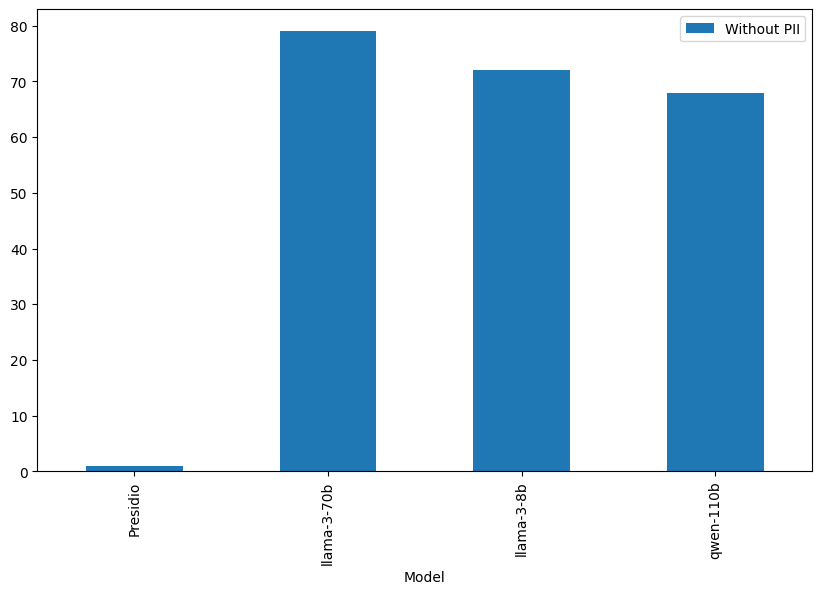

In [114]:


df = pd.read_excel('results.xlsx')

ax = df.set_index('Model').plot(kind='bar', stacked=False, figsize=(10, 6))

plt.title('Files with no PII detected')
plt.xlabel('Model')
plt.ylabel('Number of Files')
plt.xticks(rotation=0)
plt.legend(title='Category')
plt.show()


In [29]:


class PiiProcessor:
    def __init__(self, marking_agent, anonymization_agent, verification_agent):
        self.marking_agent = marking_agent
        self.anonymization_agent = anonymization_agent
        self.verification_agent = verification_agent

        # Define the chain of processes using LLMChain
        self.chain = self.create_chain()

    def create_chain(self):
        # Define the LLM for marking
        marking_prompt = PromptTemplate(input_variables=["text"], template=self.marking_agent.prompt_template + "\n\nText:\n{text}")
        marking_llm = LLaMA(api_key=self.marking_agent.api_key, model=self.marking_agent.model)
        marking_chain = LLMChain(prompt=marking_prompt, llm=marking_llm)

        # Define the anonymization and verification as functions
        def anonymization_step(text):
            return self.anonymization_agent.anonymize(text)
        
        def verification_step(text):
            if not self.verification_agent.verify(text):
                raise Exception("Anonymization failed for the text.")
            return text

        return LLMChain(
            chains=[
                marking_chain,
                anonymization_step,
                verification_step
            ]
        )

    def process_text(self, text):
        return self.chain.run({"text": text})


In [30]:
# Usage
pii_detector = MarkingAgent(OPENROUTER_API_KEY)
anonymization_agent = AnonymizationAgent()
verification_agent = VerificationAgent()

# Initialize the LangChain processor with the agents
pii_processor = PiiProcessor(pii_detector, anonymization_agent, verification_agent)

input_folder = "generated_texts2"
output_folder = "anonymized_texts2"

process_folder(input_folder, output_folder, pii_processor)

print("Texter genererade och sparade.")


NameError: name 'LLaMA' is not defined

In [ ]:
# Initialize the chain with the agents
pii_chain = PIIAnonymizationChain(pii_detector, pii_anonymizer, pii_verifier)

# Test with some input text
input_text = "Felix's email is felix@example.com."
output_text = pii_chain(input_text)
print(output_text)